# Task07 投票法的原理和案例分析

## 1 知识梳理
### 1.1 投票法的思路
- 基本思路：由于错误总是发生在局部，通过融合多个数据降低误差
- 在回归模型中的应用：投票法最终的预测结果是多个回归模型预测结果的平均值
- 在分类模型中的应用：
  - 硬投票法：多个模型预测结果中出现次数最多的类别
  - 软投票法：对各类预测结果的概率求和，选取概率之和最大的类别

### 1.2 投票法的原理分析
- 回归投票法：预测结果是所有模型预测结果的平均值
- 分类投票法：预测结果是所有模型中出现最多的预测结果
    - 硬投票：预测结果是所有投票结果最多出现的类别
    - 软投票：预测结果是所有投票结果中概率相加求和最大的类别

- 基模型的选取：  
  1. 基模型之间的效果不能差别过大，差别过大的基模型可能会成为噪声
  2. 基模型之间应该有较小的同质性，应采用多个不同的基模型
- 适用性：  
  1. 能够预测清晰的类别的数据集，可适用硬投票
  2. 能够预测类别的概率，或可得到类似的预测分数值的数据集，可适用软投票

## 2 实战练习

### 2.1 模型定义示例

使用`sklearn.ensemble.VotingClassifier`和`sklearn.ensemble.VotingRegressor`,传入模型列表，形式为`Tuple`结构，其中第一个元素设置为模型名称（可自定义），第二个元素设置为模型对象，且每个模型的名称必须唯一。

In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier

In [2]:
# 定义两个模型：Logistic回归模型和SVM模型
models = [('lr',LogisticRegression()),('svm',SVC())]

以下使用分类投票法中的软投票

In [3]:
ensemble = VotingClassifier(estimators=models, voting='soft')

### 2.2 创建自定义数据集
使用`sklearn.datasets.make_classification`方法创建数据集

In [4]:
from sklearn.datasets import make_classification

生成特征数为20，其中多信息特征数为10，冗余信息特征数为5，总样本数为1000个的数据集

In [5]:
def get_dataset():
    X, y = make_classification(n_samples=1000, n_features=20, n_informative=10,
n_redundant=5, random_state=2)
    return X, y

### 2.3 定义投票法模型

使用多个`KNN`模型作为基模型，其中每个模型使用不同的`K`值

In [6]:
def get_voting():
    # 定义投票法需要的模型列表
    models = list()
    models.append(('knn1', KNeighborsClassifier(n_neighbors=1)))
    models.append(('knn3', KNeighborsClassifier(n_neighbors=3)))
    models.append(('knn5', KNeighborsClassifier(n_neighbors=5)))
    models.append(('knn7', KNeighborsClassifier(n_neighbors=7)))
    models.append(('knn9', KNeighborsClassifier(n_neighbors=9)))
    # 得到投票法的模型，使用硬投票
    ensemble = VotingClassifier(estimators=models, voting='hard')
    return ensemble

### 2.4 创建模型列表，用于评估比较模型的效果

In [7]:
def get_models():
    models = dict()
    models['knn1'] = KNeighborsClassifier(n_neighbors=1)
    models['knn3'] = KNeighborsClassifier(n_neighbors=3)
    models['knn5'] = KNeighborsClassifier(n_neighbors=5)
    models['knn7'] = KNeighborsClassifier(n_neighbors=7)
    models['knn9'] = KNeighborsClassifier(n_neighbors=9)
    models['hard_voting'] = get_voting()
    return models

### 2.5 对单个模型进行评估
使用`sklearn.model_selection.RepeatedStratifiedKFold`对模型进行10层交叉验证（其中重复3次）评估

In [8]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1,
error_score='raise')
    return scores

### 2.6 使用箱形图进行模型比较

In [9]:
from sklearn.neighbors import KNeighborsClassifier
from matplotlib import pyplot
import numpy as np

# 得到数据集
X, y = get_dataset()
# 得到需要评估的模型列表，其中包括多个不同K值的KNN模型和分类硬投票模型
models = get_models()
# 定义结果和模型名称
results, names = [], []
for name, model in models.items():
    scores = evaluate_model(model, X, y)
    results.append(scores)
    names.append(name)
    print('模型名称：%s，mean：%.3f，std：%.3f' % (name, np.mean(scores), np.std(scores)))

模型名称：knn1，mean：0.918，std：0.025
模型名称：knn3，mean：0.926，std：0.023
模型名称：knn5，mean：0.919，std：0.029
模型名称：knn7，mean：0.919，std：0.030
模型名称：knn9，mean：0.914，std：0.033
模型名称：hard_voting，mean：0.922，std：0.028


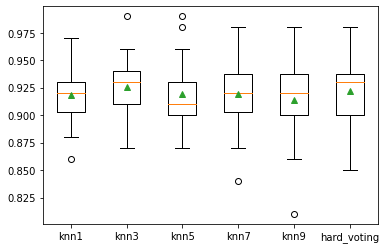

In [10]:
%matplotlib inline

pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

通过结果观察到，对于交叉验证评估，投票法比其他的基模型效果要好。